**Author**: Justine Debelius (justine.debelius@ki.se)<br>
**Date**: Summer/Fall 2021<br>
**Conda enviroment**: `micc-2021.11`<br>
**Python version**: 3.6.10<br>
**Python packages**: `pystan` (v. 2.19); `patsy` (0.5.1); <br>
**QIIME 2 version**: 2021.11<br>
**QIIME 2 plugins**: `gemeilli` (v. 0.0.7); `deicode` (v. 0.2.4)'; `empress` (v 1.1.0.dev); `songbird` (v. 1.0.4)<br>

Here, we produce Figure 2, along with corresponding supplemental tables for differenital ranking and representative fastq files.

In [75]:
import itertools as it
import os
import pickle

import biom
from matplotlib import rcParams, ticker
import matplotlib.pyplot as plt
import matplotlib_venn as venn
import numpy as np
import pandas as pd
import patsy
import scipy
from scipy.stats import t
import skbio
import statsmodels.api as sms
import statsmodels.formula.api as smf
import seaborn as sn

from qiime2 import Artifact, Metadata, Visualization

import qiime2.plugins.composition.actions as q2_comp
import qiime2.plugins.diversity.actions as q2_diversity
import qiime2.plugins.deicode.actions as q2_deicode
import qiime2.plugins.emperor.actions as q2_emperor
import qiime2.plugins.empress.actions as q2_empress
import qiime2.plugins.feature_table.actions as q2_feature_table
import qiime2.plugins.gemelli.actions as q2_gemelli

import scripts.tax_colors as tax_colors


rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
# rcParams['pdf.fonttype'] = 42
rcParams['pdf.use14corefonts'] = True
rcParams['text.usetex'] = False

np.set_printoptions(precision=5)

%matplotlib inline

# Reads in data

In [72]:
meta_q2 = Metadata.load('data/metadata_paired.tsv')
meta = meta_q2.to_dataframe()
meta.replace({"nan": np.nan}, inplace=True)
meta['tissue_num'] = (meta['tissue_type'] == 'tumor') * 1
meta_q2 = Metadata(meta)
meta['long_survival'] = meta['long_survival'].astype(int)


In [4]:
subject_meta = meta.groupby('host_subject_id').first()
subject_meta.drop(columns=['tissue_num'], inplace=True)

In [5]:
table_q2 = Artifact.load('data/tables/phylum_defined_table.qza')
# table_q2 = q2_feature_table.filter_samples(
    
# )
table_q2 = q2_feature_table.filter_features(
    table=table_q2,
     min_frequency=100, 
     min_samples=20,
).filtered_table


table = Artifact.load('data/tables/phylum_defined_table.qza').view(pd.DataFrame)

In [6]:
tree_q2 = Artifact.load('data/tree/tree_silva128.qza')

In [7]:
taxa_q2 = Artifact.load('data/tables/taxonomy.qza')
taxa = taxa_q2.view(pd.Series).apply(lambda x: pd.Series(x.split(';')))
taxa = taxa.loc[list(table_q2.view(biom.Table).ids(axis='observation'))]
taxa_meta = Metadata(taxa.rename(columns={0: 'kingdom', 1: 'phylum', 2: 'class', 3: 'order',
                                          4: 'family', 5: 'genus', 6: 'species'}))


In [8]:
state_subject_ordination = Artifact.load('data/diversity/ctf/state_subject_ordination.qza')
state_feature_ordination = Artifact.load('data/diversity/ctf/state_feature_ordination.qza')
subject_biplot = Artifact.load('data/diversity/ctf/subject_biplot.qza')
distance_matrix = Artifact.load('data/diversity/ctf/distance_matrix.qza')

# Difference between tissue types

In [9]:
# state_subject_ordination = Artifact.load('data/diversity/ctf/state_subject_ordination.qza')
state_subject_diff = state_subject_ordination.view(pd.DataFrame).copy()
state_subject_diff['PC1'] = state_subject_diff['PC1'] * -1
state_subject_diff['PC2'] = state_subject_diff['PC2'] * -1

state_subject_diff.sort_values(['subject_id', 'tissue_num'], inplace=True, 
                               ascending=True)
state_subject_diff['subject_id'] = state_subject_diff['subject_id'].astype(int).astype(str)
state_subject_diff.set_index('subject_id', inplace=True)
state_subject_diff = \
    state_subject_diff.groupby('subject_id')[['PC1', 'PC2', 'PC3']].diff().dropna()
# state_subject_diff['long_survival'] = \
#     meta.loc[state_subject_diff.index, 'long_survival']

In [10]:
tissue_coords_wide =  state_subject_ordination.view(pd.DataFrame).pivot_table(
    index='subject_id', columns='tissue_num', values=['PC1', 'PC2', 'PC3']
)
tissue_coords_wide['PC2'] = tissue_coords_wide['PC2']  * -1
tissue_coords_wide[('PC1', 'diff')] = tissue_coords_wide['PC1'].diff(axis=1)[1]
tissue_coords_wide[('PC2', 'diff')] = tissue_coords_wide['PC2'].diff(axis=1)[1]
tissue_coords_wide[('PC3', 'diff')] = tissue_coords_wide['PC3'].diff(axis=1)[1]
tissue_coords_wide[("PC23", 'radius')] = \
    np.sqrt(np.square(tissue_coords_wide[[('PC2', 'diff'), ("PC3", 'diff')]]).sum(axis=1))
tissue_coords_wide[('PC23', 'theta')] = (
     np.arctan(tissue_coords_wide[("PC3", 'diff')] / 
               tissue_coords_wide[("PC2", 'diff')]) + 
     np.pi * (tissue_coords_wide[("PC2", 'diff')] < 0)
     )
tissue_coords_wide.sort_index(axis='columns', inplace=True)

tissue_coords_wide.index = tissue_coords_wide.index.astype(float).astype(int).astype(str)

tissue_coords_wide[('survival', '')] = subject_meta['long_survival']

PC1                            PC2                      \
tissue_num        0.0        1.0      diff       0.0       1.0      diff   
subject_id                                                                 
33          -6.633718  -6.658095 -0.024377 -4.836018 -3.916296  0.919721   
38           5.247510   5.246867 -0.000643  3.369792  3.591859  0.222067   
47           0.785955   0.776400 -0.009555  5.947722  5.950616  0.002893   
48           2.621205   2.615315 -0.005889 -2.317743 -1.612124  0.705619   
73          -0.911528  -0.924474 -0.012946 -0.362722  0.176682  0.539404   
...               ...        ...       ...       ...       ...       ...   
485        -11.309535 -11.343253 -0.033717  1.017773  1.439808  0.422035   
498         -0.512999  -0.525149 -0.012150 -1.658579 -1.009002  0.649577   
507         16.465192  16.486957  0.021765  7.488219  7.360140 -0.128079   
512        -17.172123 -17.217551 -0.045428  0.599399  1.057004  0.457605   
540         12.454647  12.468401  0.013754  7.469083  7.342630 -0.126452   

                PC23                 PC3                     survival  
tissue_num    radius     theta       0.0       1.0      diff           
subject_id                                                             
33          1.189182  0.686599 -6.720511 -5.966676  0.753835        1  
38          1.802423  1.447278  2.450458  4.239149  1.788691        0  
47          2.126852  1.569436  5.447255  7.574106  2.126850        0  
48          1.934300  1.197386  2.559587  4.360592  1.801005        0  
73          1.201670  1.105287 -3.884922 -2.811117  1.073804        0  
...              ...       ...       ...       ...       ...      ...  
485         1.809992  1.335461  2.197094  3.957196  1.760101        0  
498         1.201165  0.999421 -4.447079 -3.436709  1.010370        0  
507         1.747493  1.644155  2.043713  3.786507  1.742793        0  
512         1.712985  1.300374  1.227860  2.878592  1.650732        0  
540         2.116023  1.630591  5.317784  7.430024  2.112241        0  

[101 rows x 12 columns]

# DR, Tissue
I want to start by looking at the model we got for tissue without considering ssurvival, and see if there's a larger difference there.

In [12]:
tissue_ranks = pd.read_csv('data/differential_ranking/tissue_num_1000.tsv', sep='\t')
tissue_ranks.set_index('feature-id', inplace=True)
tissue_ranks = \
    tissue_ranks.loc[tissue_ranks.index.isin(table_q2.view(pd.DataFrame).columns)]
tissue_ranks.sort_values('tissue_rank', ascending=True, inplace=True)

In [13]:
table_pres = (table_q2.view(pd.DataFrame) > 0) * 1

In [14]:
t_lo = table_pres[tissue_ranks.index].cummax(axis=1).sum(axis=0)
t_lo = t_lo[(t_lo < 202) | ~t_lo.duplicated(keep='first')].index

t_hi = table_pres[tissue_ranks.index[::-1]].cummax(axis=1).sum(axis=0)
t_hi = t_hi[(t_hi < 202) | ~t_hi.duplicated(keep='first')].index

In [15]:
meta['tissue_only_alr'] = \
    np.log2(table_q2.view(pd.DataFrame)[t_hi].sum(axis=1) / 
            table_q2.view(pd.DataFrame)[t_lo].sum(axis=1)
            )

In [16]:
fit_ = smf.mixedlm('tissue_only_alr ~ long_survival',
                   data=meta,
                   groups=meta['host_subject_id'],
                   ).fit()
print(fit_.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: tissue_only_alr
No. Observations: 202     Method:             REML           
No. Groups:       101     Scale:              3.0901         
Min. group size:  2       Log-Likelihood:     -469.0229      
Max. group size:  2       Converged:          Yes            
Mean group size:  2.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept      -0.724     0.349  -2.076  0.038  -1.407  -0.041
long_survival  -0.963     0.491  -1.962  0.050  -1.924  -0.001
Group Var       4.534     0.692                               



In [17]:
meta['short_survival'] = (meta['long_survival'] == 0) * 1
fit_ = smf.mixedlm('tissue_only_alr ~ short_survival + tissue_num',
                   data=meta,
                   groups=meta['host_subject_id'],
                   ).fit()
print(fit_.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: tissue_only_alr
No. Observations: 202     Method:             REML           
No. Groups:       101     Scale:              1.5189         
Min. group size:  2       Log-Likelihood:     -433.4901      
Max. group size:  2       Converged:          Yes            
Mean group size:  2.0                                        
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -2.577    0.356 -7.240 0.000 -3.275 -1.879
short_survival      0.963    0.491  1.962 0.050  0.001  1.924
tissue_num          1.781    0.173 10.270 0.000  1.441  2.121
Group Var           5.319    0.989                           



In [18]:
meta['short_survival'] = (meta['long_survival'] == 0) * 1
fit_ = smf.mixedlm('tissue_only_alr ~ short_survival*tissue_num',
                   data=meta,
                   groups=meta['host_subject_id'],
                   ).fit()
print(fit_.summary())

               Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   tissue_only_alr
No. Observations:    202       Method:               REML           
No. Groups:          101       Scale:                1.4822         
Min. group size:     2         Log-Likelihood:       -431.9199      
Max. group size:     2         Converged:            Yes            
Mean group size:     2.0                                            
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 -2.419    0.366 -6.615 0.000 -3.136 -1.702
short_survival             0.643    0.520  1.238 0.216 -0.375  1.662
tissue_num                 1.465    0.241  6.076 0.000  0.992  1.937
short_survival:tissue_num  0.639    0.343  1.864 0.062 -0.033  1.310
Group Var                  5.337    1.004         

## DR, Interaction

We have to flip the sign on tissue so it ends up in the same direction as the change in the CTF.

In [19]:
interaction_ranks = pd.read_csv('data/differential_ranking/interaction_model_1000.tsv',
                    sep='\t')
interaction_ranks.set_index('feature-id', inplace=True)
interaction_ranks = interaction_ranks.loc[
    interaction_ranks.index.isin(table_q2.view(pd.DataFrame).columns)]

In [20]:
interaction_ranks['survival_mean'] = interaction_ranks['survival_mean']
interaction_ranks.sort_values('survival_mean', inplace=True, ascending=True)
interaction_ranks['survival_rank'] = 1
interaction_ranks['survival_rank'] = \
    interaction_ranks['survival_rank'].cumsum() - 1
surv_lo = table_pres[interaction_ranks.index].cummax(axis=1).sum(axis=0)
surv_lo = surv_lo[(surv_lo < 202) | ~surv_lo.duplicated(keep='first')].index
surv_hi = table_pres[interaction_ranks.index[::-1]].cummax(axis=1).sum(axis=0)
surv_hi = surv_hi[(surv_hi < 202) | ~surv_hi.duplicated(keep='first')].index
interaction_ranks['survival_group'] = \
    interaction_ranks.index.to_frame()['feature-id'].isin(surv_lo) * -1 + \
    interaction_ranks.index.to_frame()['feature-id'].isin(surv_hi) * 1

# interaction_ranks['tissue_mean'] = interaction_ranks['tissue_mean'] * -1
interaction_ranks.sort_values('tissue_mean', inplace=True, ascending=True)
interaction_ranks['tissue_rank'] = 1
interaction_ranks['tissue_rank'] = interaction_ranks['tissue_rank'].cumsum() - 1
tissue_lo = table_pres[interaction_ranks.index].cummax(axis=1).sum(axis=0)
tissue_lo = tissue_lo[(tissue_lo < 202) | ~tissue_lo.duplicated(keep='first')].index
tissue_hi = table_pres[interaction_ranks.index[::-1]].cummax(axis=1).sum(axis=0)
tissue_hi = tissue_hi[(tissue_hi < 202) | ~tissue_hi.duplicated(keep='first')].index
interaction_ranks['tissue_group'] = \
    interaction_ranks.index.to_frame()['feature-id'].isin(tissue_lo) * -1 + \
    interaction_ranks.index.to_frame()['feature-id'].isin(tissue_hi) * 1

# interaction_ranks['inter_mean'] = interaction_ranks['inter_mean'] * -1

interaction_ranks.sort_values('inter_mean', inplace=True, ascending=True)
interaction_ranks['inter_rank'] = 1
interaction_ranks['inter_rank'] = interaction_ranks['inter_rank'].cumsum() - 1
tissue_lo = table_pres[interaction_ranks.index].cummax(axis=1).sum(axis=0)
tissue_lo = tissue_lo[(tissue_lo < 202) | ~tissue_lo.duplicated(keep='first')].index
tissue_hi = table_pres[interaction_ranks.index[::-1]].cummax(axis=1).sum(axis=0)
tissue_hi = tissue_hi[(tissue_hi < 202) | ~tissue_hi.duplicated(keep='first')].index
interaction_ranks['inter_group'] = \
    interaction_ranks.index.to_frame()['feature-id'].isin(tissue_lo) * -1 + \
    interaction_ranks.index.to_frame()['feature-id'].isin(tissue_hi) * 1

In [21]:
interaction_ranks['combo_group'] = \
    interaction_ranks['tissue_group'] * 2 + \
    interaction_ranks['inter_group'] * 0.5                                                                                    

In [22]:
rank_cols = ['survival', 'tissue', 'inter']
id_lookup = {
    term: {
        name: set(interaction_ranks.index[interaction_ranks[f'{term}_group'] == v])
        for name, v in zip(*(['lo', 'hi'], [-1, 1]))
    }
    for term in rank_cols
}


In [23]:
normal_assoc_gene = taxa.loc[interaction_ranks.index[interaction_ranks['inter_group'] == -1]].copy()
normal_assoc_gene.drop(columns=[0, 6], inplace=True)
normal_assoc_gene.drop_duplicates(inplace=True)
normal_assoc_gene.sort_values(list(normal_assoc_gene.columns), ascending=True, inplace=True)
normal_assoc_gene

,1,2,3,4,5
feature-id,,,,,
Sene-781430c,p__Actinobacteria,c__Coriobacteriia,o__Coriobacteriales,f__Coriobacteriaceae,g__Senegalimassilia
Barn-53f976e,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Porphyromonadaceae,g__Barnesiella
Alis-0ce6000,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Rikenellaceae,g__Alistipes
Chri-fb2e43a,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Christensenellaceae,g__Christensenellaceae_R-7_group
Lach-3a2e845,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,f__Lachnospiraceae
Anae-2ee585c,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__Anaerostipes
Hung-78c2b8e,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__Hungatella
Lach-7cd4efa,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__Lachnoclostridium
Lach-7079408,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__Lachnospiraceae_NK4A136_group


In [24]:
tumor_assoc_taxa = taxa.loc[interaction_ranks.index[interaction_ranks['inter_group'] == 1]].copy()
tumor_assoc_taxa.drop(columns=[0, 6], inplace=True)
tumor_assoc_taxa.drop_duplicates(inplace=True)
tumor_assoc_taxa.sort_values(list(tumor_assoc_taxa.columns), ascending=True, inplace=True)
tumor_assoc_taxa

,1,2,3,4,5
feature-id,,,,,
Bifi-f633cf9,p__Actinobacteria,c__Actinobacteria,o__Bifidobacteriales,f__Bifidobacteriaceae,g__Bifidobacterium
Bact-b74ab69,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides
Barn-f674778,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Porphyromonadaceae,g__Barnesiella
Para-218f40f,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Porphyromonadaceae,g__Parabacteroides
Para-3d48874,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Prevotellaceae,g__Paraprevotella
Gast-90e9bc6,p__Cyanobacteria,c__Melainabacteria,o__Gastranaerophilales,o__Gastranaerophilales,o__Gastranaerophilales
Meth-26639d9,p__Euryarchaeota,c__Methanobacteria,o__Methanobacteriales,f__Methanobacteriaceae,g__Methanobrevibacter
Chri-b03de84,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Christensenellaceae,g__Christensenellaceae_R-7_group
Clos-875f9ef,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Clostridiaceae_1,g__Clostridium_sensu_stricto_1


In [26]:
table_s5 = interaction_ranks[[c for c in interaction_ranks.columns if 'tissue' in c]].copy()
table_s5 = table_s5.loc[table_s5['tissue_group'].isin([-1, 1])].copy()
taxa_s5 = taxa.loc[table_s5.index].copy().drop(columns=[0, 6])
taxa_s5[4] = taxa_s5[4].apply(lambda x: x.replace('o__', 'f__unsp. o__'))
taxa_s5[5] = taxa_s5[5].apply(lambda x: x.replace('o__', 'g__unsp. o__'))
taxa_s5[5] = taxa_s5[5].apply(lambda x: x.replace('f__', 'g__unsp. f__'))
table_s5['taxonomy'] = \
    taxa_s5.apply(lambda x: '; '.join(x.values).replace("__", '. '), axis=1)
table_s5['prevelance'] = table_pres[table_s5.index].mean(axis=0)
# table_s5.head()
table_s5.sort_values('tissue_rank', ascending=True, inplace=True)
table_s5['cumulative_prev'] = \
    table_pres[table_s5[table_s5['tissue_group'] == -1].index].cummax(axis=1).mean(axis=0)

table_s5.sort_values('tissue_rank', ascending=False, inplace=True)
table_s5.loc[table_s5['cumulative_prev'].isna(), 'cumulative_prev'] = \
    table_pres[table_s5.index[table_s5['cumulative_prev'].isna()]].cummax(axis=1).mean(axis=0)

table_s5.to_csv('output/tables/table_s5_tissue_ranks.tsv', sep='\t')

In [27]:
table_s6 = interaction_ranks[[c for c in interaction_ranks.columns if 'inter' in c]].copy()
table_s6 = table_s6.loc[table_s6['inter_group'].isin([-1, 1])].copy()
table_s6.head()
taxa_s6 = taxa.loc[table_s6.index].copy().drop(columns=[0, 6])
taxa_s6[4] = taxa_s6[4].apply(lambda x: x.replace('o__', 'f__unsp. o__'))
taxa_s6[5] = taxa_s6[5].apply(lambda x: x.replace('o__', 'g__unsp. o__'))
taxa_s6[5] = taxa_s6[5].apply(lambda x: x.replace('f__', 'g__unsp. f__'))
table_s6['taxonomy'] = \
    taxa_s6.apply(lambda x: '; '.join(x.values).replace("__", '. '), axis=1)
table_s6['prevelance'] = table_pres[table_s6.index].mean(axis=0)
table_s6.head()
table_s6.sort_values('inter_rank', ascending=True, inplace=True)
table_s6['cumulative_prev'] = \
    table_pres[table_s6[table_s6['inter_group'] == -1].index].cummax(axis=1).mean(axis=0)

table_s6.sort_values('inter_rank', ascending=False, inplace=True)
table_s6.loc[table_s6['cumulative_prev'].isna(), 'cumulative_prev'] = \
    table_pres[table_s6.index[table_s6['cumulative_prev'].isna()]].cummax(axis=1).mean(axis=0)

table_s6.to_csv('output/tables/table_s6_inter_ranks.tsv', sep='\t')
# table_s6

In [28]:
# table_s5.to_csv('output/tables/table_s5_interaction_model.tsv', sep='\t')
# table_s5.to_excel('output/tables/table_s5_interaction_model.xlsx')

In [29]:
interaction_ranks['color_group'] = taxa[4].apply(
    lambda x: tax_colors.remappings.get(x, 'Other')
).replace(tax_colors.mapped_colors)
# interaction_ranks['color_group'] = \

In [30]:
meta['survival_alr'] = np.log2(
    table[interaction_ranks.index[interaction_ranks['survival_group'] == 1]].sum(axis=1) / 
    table[interaction_ranks.index[interaction_ranks['survival_group'] == -1]].sum(axis=1)
)
meta['tissue_alr'] = np.log2(
    table[interaction_ranks.index[interaction_ranks['tissue_group'] == 1]].sum(axis=1) / 
    table[interaction_ranks.index[interaction_ranks['tissue_group'] == -1]].sum(axis=1)
)
meta['inter_alr'] = np.log2(
    table[interaction_ranks.index[interaction_ranks['inter_group'] == 1]].sum(axis=1) / 
    table[interaction_ranks.index[interaction_ranks['inter_group'] == -1]].sum(axis=1)
)

In [31]:
eqs = {'model 1': 'short_survival + tissue_num', 
       'model 2': 'short_survival + tissue_num + surgery_year + ana_location', 
       'model 3': 'short_survival*tissue_num', 
       'model 4': 'short_survival*tissue_num + surgery_year + ana_location', 
       'model 5': 'short_survival',
       'model 6': 'short_survival + surgery_year + ana_location', 
      }
alrs = ['survival_alr', 'tissue_alr', 'inter_alr']

In [32]:
alr_fits = {
    (alr, model): smf.mixedlm(f'{alr} ~ {eq}', 
                           data=meta, 
                           groups=meta['host_subject_id']).fit()
    for alr, (model, eq) in it.product(alrs, eqs.items())
}

In [33]:
def assemble_params(fit_):
    fit_ = pd.concat(axis=1, objs=[fit_.params, fit_.conf_int(), fit_.pvalues])
    fit_.columns = ['param', 'ci_lo', 'ci_hi', 'p-value']
    fit_.drop(index=['Intercept', 'Group Var'], inplace=True)
    return fit_
    

In [34]:
alr_params = pd.DataFrame({k: assemble_params(fit_).unstack() 
                           for k, fit_ in alr_fits.items()})
alr_params.index.set_names(['statistic', 'group'], inplace=True)
alr_params.columns.set_names(['alr', 'model'], inplace=True)
alr_params = alr_params.reset_index().melt(id_vars=['statistic', 'group'])
alr_wide = alr_params.pivot_table(index=['alr', 'group'], 
                                  columns=['model', 'statistic'], 
                                  values='value')
alr_untidy = alr_params.pivot_table(index=['alr', 'model', 'group'], 
                                    columns=['statistic'], 
                                    values='value')
alr_untidy['clean'] = alr_untidy.apply(
    lambda x: '{param:>5.2f} ({ci_lo:>5.2f}, {ci_hi:>5.2f})'.format(**x.to_dict()),
    axis=1
)
# alr
alr_tidied = pd.concat(axis=0, objs=[
    alr_untidy['clean'].unstack([0]),
    pd.DataFrame(
        data=np.array([[''] * 3] * 3, dtype=object),
        columns=pd.Index(['inter_alr', 'survival_alr', 'tissue_alr'],
                         name='alr'),
        index=pd.MultiIndex.from_arrays(
            np.array([['model 1', 'model 2', 'model 3'], ['', '', '']]),
            names=['model', 'group'],
        )
    )
])

alr_tidied.sort_index(inplace=True)
alr_tidied.to_csv('output/tables/table_s6_alr_fits.tsv', sep='\t')
alr_tidied.to_excel('output/tables/table_s6_alr_fits.xlsx')

In [35]:
alr_wide.drop(index=['surgery_year[T.1.2006-2010]', 'surgery_year[T.2.2011-2017]', 
                     'ana_location[T.1.left colon]', 'ana_location[T.2.rectum]'
                     ],
              level='group',
              inplace=True
             )

# FIGURE

In [37]:
# rank_cols = ['survival', 'tissue', 'inter']
dr_alr = pd.DataFrame({
    term: np.log2(
        table[interaction_ranks.index[interaction_ranks[f'{term}_group'] == 1]].sum(axis=1) / 
        table[interaction_ranks.index[interaction_ranks[f'{term}_group'] == -1]].sum(axis=1)
    )
    for term in rank_cols
})
dr_alr[['subject_id', 'tissue_type']] = meta[['host_subject_id', 'tissue_type']]
dr_alr.sort_values(['subject_id', 'tissue_type'], ascending=True, inplace=True)
dr_alr.set_index('subject_id', inplace=True)

In [38]:
df_alr_diff = dr_alr.groupby(['subject_id'], sort=False)[['survival', 'tissue', 'inter']].diff().dropna()

,survival,tissue,inter
subject_id,,,
145,-0.058452,0.714633,0.259990
148,-1.899422,-1.487705,0.883487
150,-0.972001,0.914028,-0.492318
152,-0.293853,-0.248033,0.122918
160,-0.086638,0.732463,1.891822
...,...,...,...
507,0.010867,1.398063,0.493098
512,-0.565959,0.542656,-0.128532
540,-3.860056,3.314977,2.618970


In [39]:
rank_cols = ['survival', 'tissue', 'inter']
dr_alr = pd.DataFrame({
    term: np.log2(
        table[interaction_ranks.index[interaction_ranks[f'{term}_group'] == 1]].sum(axis=1) / 
        table[interaction_ranks.index[interaction_ranks[f'{term}_group'] == -1]].sum(axis=1)
    )
    for term in rank_cols
})
dr_alr[['subject_id', 'tissue_type']] = meta[['host_subject_id', 'tissue_type']]
dr_alr.sort_values(['subject_id', 'tissue_type'], ascending=True, inplace=True)
dr_alr.set_index('subject_id', inplace=True)

In [40]:
diffs = pd.concat(axis=1, objs=[
    subject_meta, 
    state_subject_diff,
    pd.concat(axis=0, objs=[
        state_subject_diff[['PC1', 'PC2', 'PC3']] >= q[['PC1', 'PC2', 'PC3']]
        for _, q in state_subject_diff.quantile(np.arange(3) / 3).iterrows()
    ]).groupby('subject_id').sum().add_suffix('_q3') - 1,
    df_alr_diff,
    pd.concat(axis=0, objs=[
        df_alr_diff >= q 
        for q in df_alr_diff.quantile(np.arange(3) / 3).values
    ]).groupby('subject_id').sum().add_suffix('_q3') - 1,
])

In [41]:
from scipy.stats import ttest_ind
def permutative_welchs(labeled, groups, target, nperm=999):
    params = labeled.groupby(groups)[target].describe()
    
    spool = np.sqrt((np.square(params['std']) * (params['count'] - 1)).sum() / 
                    params['count'].sum())
    
    d = params['mean'].diff().dropna()[1] / spool
    
    new_labels = pd.DataFrame(
        np.vstack([np.random.permutation(labeled[groups].values)
                            for i in range(nperm)]).T,
        index=labeled.index
    )
    new_labels['ref'] = labeled[groups]
    new_labels['v'] = labeled[target]
    
    res_ = pd.DataFrame({
        c: ttest_ind(*new_labels.groupby(c)['v'].apply(lambda x: x.values), 
                     equal_var=False)
        for c in new_labels.columns if (c != 'v')
    }).T
    ref_value = res_.loc['ref', 0]
    ref_sign = np.sign(ref_value)
    res_['adj'] = (res_[0] * ref_sign)# >= (ref_value * ref_sign)
    res_['extreme'] = res_['adj'] >= (ref_value * ref_sign)
    p_iter = res_['extreme'].mean()
#     p_iter = res_['adj'].sum() / len(res_)

    return ref_sign, ref_value, p_iter, np.absolute(d)
permutative_welchs(diffs, 'long_survival', 'PC1', 999)


(-1.0, -0.6734704184740787, 0.252, 0.13552406812772977)

In [42]:
surv_colors =  {0: '#4292c6', 1: '#08306b'}
 # {"0": '#4292c6', '1': '#08306b'}

In [43]:
def fit_alr(term):
    """
    Gets the alr ratio for a term
    """
    lo_ = interaction_ranks.index[interaction_ranks[f'{term}_group'] == -1]
    hi_ = interaction_ranks.index[interaction_ranks[f'{term}_group'] == 1]
    alr_v = pd.DataFrame({
        'subject_id': meta['host_subject_id'],
        'tissue': meta['tissue_num'],
        'survival': meta['long_survival'],
        'alr': np.log2((table[hi_] + 1).sum(axis=1) / (table[lo_] + 1).sum(axis=1))
    })

    alr_v.sort_values(['subject_id', 'tissue'], ascending=True, inplace=True)
    alr_v.set_index(['survival', 'subject_id'], inplace=True)
    alr_d = alr_v.groupby(['survival', 'subject_id'], sort=False).diff().dropna()
    alr_d.reset_index(inplace=True)
    alr_v.reset_index(level='survival', inplace=True)
    
    alr_w = alr_v.reset_index().pivot_table(index=['survival', 'subject_id'],
                                            columns='tissue',
                                            values='alr')

    tops = alr_w.groupby('survival').max().T
    tops['max'] = tops.max(axis=1)
    
    fits = dict([])
    for surv in np.arange(0, 2):
        data = alr_v.reset_index().copy()
        data = data.loc[data['survival'] == surv]
        fits[('surv', surv)] = smf.mixedlm('alr ~ tissue', 
                                           data=data, 
                                           groups=data['subject_id']).fit()

    
    fits[('inter', 'd')] = \
        smf.mixedlm('alr ~ survival', 
                    data=alr_v.reset_index(), 
                    groups=alr_v.reset_index()['subject_id']
                   ).fit()
    
    p_vals = pd.Series({k: v.pvalues[1] for k, v in fits.items()})
    p_str = np.floor(-np.log10(p_vals + 0.05 * (p_vals > 0.05))).astype(int)
    p_str = p_str.apply(lambda x: ''.join(['*'] * min(max(x, 0), 3)))
    
    fits['full'] = smf.mixedlm('alr ~ survival * tissue', 
                               data=alr_v.reset_index(), 
                               groups=alr_v.reset_index()['subject_id']).fit()
    
    return alr_v, alr_w, fits, p_str

In [111]:
def make_rank_plot(ax_rank, ranks, term, colors, inset=True, offset_values=None, 
                   ylabel=''):
    """
    Creates a stacked barchart with ranks, highlighting the taxa in the
    ranked groups
    """
    # Plots the general rank
    ax_rank.bar(
        x=ranks[f'{term}_rank'],
        height=ranks[f'{term}_mean'],
        width=1,
        color=ranks[f'{term}_group'].replace(colors),
    )
    ax_rank.plot([-5, len(ranks) + 5], [0, 0], 'k-')
    
    # Cleans up the axes for plotting
    ax_rank.set_xlim(-5, len(ranks) + 5)
    ax_rank.set_xlabel('Relative Rank')
    ax_rank.set_ylabel(ylabel)
    
    # Gets limits so we can appropriately set the data
    top = np.ceil(np.absolute(ranks[f'{term}_mean']).max() * 1.1 * 4) / 4
    xdelta = np.diff(ax_rank.get_xlim())[0]
    
    inset_kwargs = dict(zorder=2, facecolor='None', edgecolor='k', 
                        linewidth=1.25)
    # Plots boxes around extreme groups
    ax_rank.fill_between(x=[-0.5, (ranks[f'{term}_group'] == -1).sum() - 0.5],
                         y1=0, y2=-1 * top,
                         **inset_kwargs)
    ax_rank.fill_between(
        x=ranks[f'{term}_rank'].max() - np.array([-0.5, (ranks[f'{term}_group'] == 1).sum() - 0.5]),
        y1=0, y2=1 * top,
        **inset_kwargs)

    # Sets up the axes based on the boxes
    ylim = ax_rank.get_ylim()
    ylim = np.array([-1, 1]) * np.absolute(ylim).max()
    ydelta = ylim[1]
    ax_rank.set_ylim(ylim)
    ax_rank.xaxis.set_tick_params(labelbottom=False, bottom=False)
    
    # Plots the colored inset
    lo_ids = ranks.index[ranks[f'{term}_group'] == -1]
    lo_rank = ranks.loc[lo_ids, f'{term}_rank']
    lo_mean = ranks.loc[lo_ids, f'{term}_mean']
    lo_color = ranks.loc[lo_ids, 'color_group']
    
    # print(lo_rank)

    # Plots low wrapper box
    ax_rank.fill_between(
        x=(np.array([lo_rank.min(), lo_rank.max() + 1]) *  0.015 + 0.1) * xdelta,
        y1=ydelta * 0.1,
        y2=ydelta * 0.9,
        facecolor='None',
        edgecolor='k',
        linewidth=2,
        )
    ax_rank.fill_between(
        x=[0, (lo_rank.min() * 0.015 + 0.1) * xdelta],
        y1=[0, ydelta*0.85], y2=[0, ydelta*0.91],
        color='k',
        )
    ax_rank.fill_betweenx(
        x1=[lo_rank.max(), ((lo_rank.max() + 1) * 0.015 + 0.1) * xdelta], 
        x2=[lo_rank.max(), ((lo_rank.max() + 1) * 0.015 + 0.09) * xdelta],
        y=[-top, ydelta*0.10], 
        color='k',
        zorder=0,
    )
    # Plots low bars
    ax_rank.bar(
        x=(lo_rank + 0.5) * 0.015 * xdelta + xdelta * 0.1,
        bottom=ydelta * 0.9,
        height = 0.8 * ydelta * (lo_mean / top),
        width=xdelta * 0.015,
        edgecolor='k',
        color=lo_color,
        zorder=0,
    )
        
    # Extracts data for the "hi" group
    hi_ids = ranks.index[ranks[f'{term}_group'] == 1]
    hi_rank = ranks.loc[hi_ids, f'{term}_rank']
    hi_mean = ranks.loc[hi_ids, f'{term}_mean']
    hi_colors = ranks.loc[hi_ids, 'color_group']
    sub_rank = hi_rank.max() - np.array([hi_rank.min() - 1, hi_rank.max()])

    # Plots the high wrapper
    ax_rank.fill_between(
        x=(sub_rank * -1 * 0.015 + 0.85) * xdelta,
        y1=-ydelta * 0.1, 
        y2=-ydelta * 0.9,
        facecolor='None',
        edgecolor='k',
        linewidth=2,
    )
    ax_rank.fill_between(
        x=[hi_rank.max(), (sub_rank.min() * -1 * 0.015 + 0.85) * xdelta],
        y1=[0, -ydelta*0.85], y2=[0, -ydelta*0.91],
        color='k',
    )
    ax_rank.fill_betweenx(
        x1=[hi_rank.min(), ((sub_rank * -1 * 0.015 + 0.85) * xdelta).min()],
        x2=[hi_rank.min(), ((sub_rank * -1 * 0.015 + 0.8625) * xdelta).min()],
        y=[top, -ydelta*0.10], 
        color='k',
        zorder=0,
    )
    # Plots the ranks
    ax_rank.bar(
        x=(0.85 - (hi_rank.max() - hi_rank + 0.49) * 0.015) * xdelta,
        bottom=ydelta * -0.9,
        height=0.8 * ydelta / top * hi_mean,
        width=xdelta * 0.015,
        edgecolor='k',
        color=hi_colors,
        zorder=0,
    )
    sn.despine(ax=ax_rank, top=True, bottom=True, right=True, trim=False)

    ax_rank.text(5, 0.05, 'Low', ha='left',
                 va='bottom', color=colors[-1], 
                 )
    ax_rank.text(len(ranks) - 5, -0.075, 'High', ha='right',
                 va='top', color=colors[1], 
                 )
    

In [112]:
color_order = [
    pd.Series(['f__Lachnospiraceae', 'f__Ruminococcaceae', 'c__Clostridia', 'c__Bacilli', 'p__Firmicutes']), # Firmictutes
    pd.Series(['f__Bacteroidaceae', 'f__Rikenellaceae', 'f__Porphyromonadaceae', 'f__Prevotellaceae', 'p__Bacteroidetes']),
    pd.Series(['f__Fusobacteriaceae', 'c__Gammaproteobacteria', 'f__Campylobacteraceae', 'p__Proteobacteria']), # Proteobacteria
    pd.Series([ 'f__Bifidobacteriaceae', 'f__Verrucomicrobiaceae', 'f__Synergistaceae', 'Other']),
]
proteo = ['c__Gammaproteobacteria', 'f__Campylobacteraceae', 'p__Proteobacteria']
phyla = ['Firmicutes', 'Bacteriodetes', ['Fusobacterium', 'Proeobacteria'], 'Other']

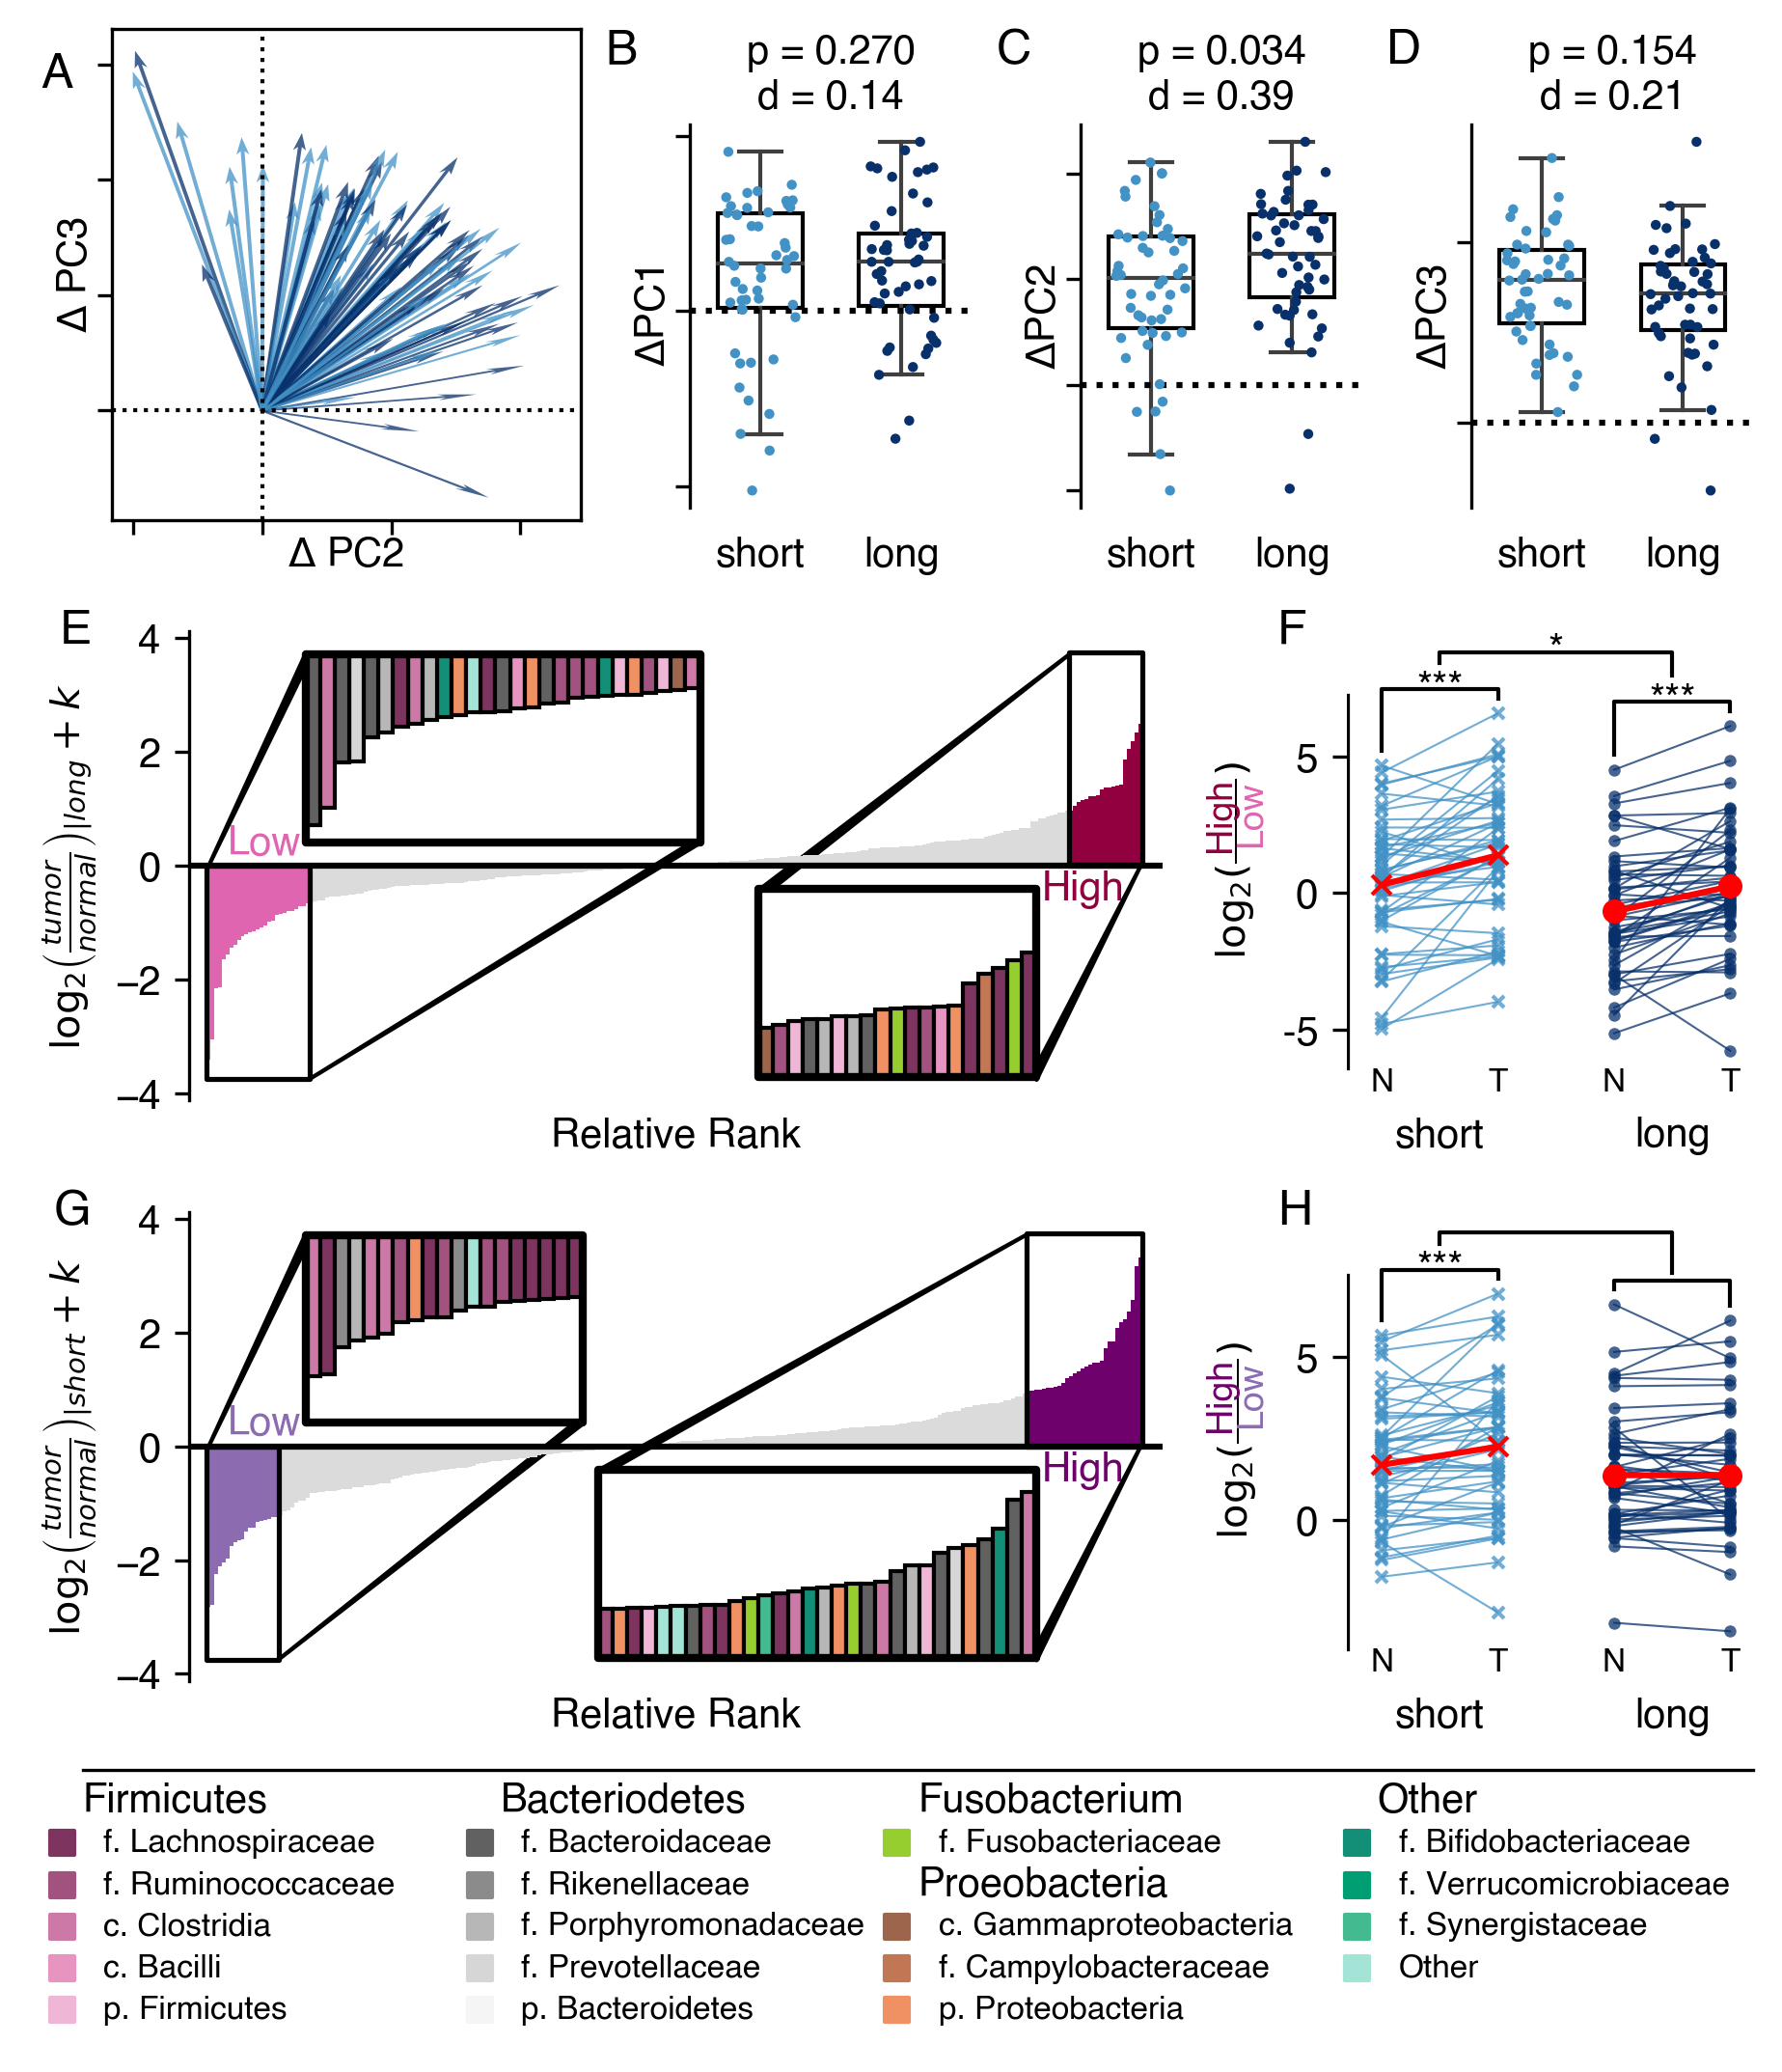

In [118]:
fig = plt.figure(
    # dpi=150,
    dpi=300, 
    constrained_layout=True,
    facecolor='w',
    figsize=(6, 7),
    )
top_fig, middle_fig, lower_fig, fig_leg = fig.subfigures(4, 1, wspace=0.01, height_ratios=[2/7, 2/7, 2/7, 1/7])

### Upper row
gs1 = top_fig.add_gridspec(1, 5)

np.random.seed(1776)


### Boxplot along axes
for i, pc in enumerate(['PC1', 'PC2', 'PC3']):
    ax = top_fig.add_subplot(gs1[:, i + 2])
    sn.boxplot(
        x='long_survival',
        y=pc,
        data=diffs,
        linewidth=1,
        fliersize=0,
        width=0.6,
        ax=ax,
        boxprops=dict(facecolor='w', edgecolor='k'),
    )
    sn.stripplot(
         x='long_survival',
        y=pc,
        data=diffs,
        edgecolor='None',
        palette=surv_colors,
        marker='.',
        jitter=0.25,
        s=5,
#         alpha=0.75,
        ax=ax,
    )
    ax.plot(ax.get_xlim(), [0, 0], 'k:')
    ax.set_ylabel(f"$\Delta${pc}")
    ax.set_xticklabels(['short', 'long'])
    ax.xaxis.set_tick_params(bottom=False)
    sn.despine(ax=ax, bottom=True, top=True, right=True, trim=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xlabel(
        'p = {2:1.3f}\nd = {3:1.2f}'.format(
            *permutative_welchs(diffs, 'long_survival', pc, 999)
    ))
    ax.xaxis.set_label_position('top') 
    ax.text((ax.get_xlim()[0] - 0.3 * np.absolute(np.diff(ax.get_xlim()))),
            (ax.get_ylim()[1] + 0.25 * np.absolute(np.diff(ax.get_ylim()))),
            list('BCD')[i], 
             size=12, 
             ha='left', 
             va='top')

### Arrow plot
ax_ord3 = top_fig.add_subplot(gs1[0, 0:2].subgridspec(1,1)[:])

ax_ord3.scatter(state_subject_diff['PC2'],
                 state_subject_diff['PC3'], 
                 s=0,
                 )
for subject, [pc1, pc2] in state_subject_diff[['PC2', 'PC3']].iterrows():
    ax_ord3.arrow(x=0, dx=pc1, 
                  y=0, dy=pc2, 
                  length_includes_head=True,
                  facecolor=surv_colors[subject_meta.loc[subject, 'long_survival']],
                  width=0.015,
                  head_width=0.05,
                  head_length=0.15,
                  overhang=0.2,
                  edgecolor='None',
                  alpha=0.75,
                  )
ax_ord3.set_ylabel('$\Delta \left ( \right )')
ax_ord3.set_xlabel('$\Delta$ PC2')
ax_ord3.set_ylabel('$\Delta$ PC3')

ax_ord3.set_xticks(top_fig.axes[1].get_yticks())
ax_ord3.set_yticks(top_fig.axes[2].get_yticks())
ax_ord3.set_xlim(top_fig.axes[1].get_ylim())
ax_ord3.set_ylim(top_fig.axes[2].get_ylim())


ax_ord3.xaxis.set_tick_params(labelbottom=False)
ax_ord3.yaxis.set_tick_params(labelbottom=False)

ord3_xlim = ax_ord3.get_xlim()
ord3_ylim = ax_ord3.get_ylim()

ax_ord3.plot(ord3_xlim, [0, 0], 'k:', linewidth=1)
ax_ord3.plot([0, 0], ord3_ylim, 'k:', linewidth=1)

ax_ord3.set_xlim(top_fig.axes[1].get_ylim())
ax_ord3.set_ylim(top_fig.axes[2].get_ylim())

ax_ord3.text(ax_ord3.get_xlim()[0] - np.diff(ax_ord3.get_xlim()) * 0.15,
             ax_ord3.get_ylim()[1] - np.diff(ax_ord3.get_ylim()) * 0.05,
             'A', size=12, ha='left', va='top'
             )

fig_low_left, fig_low_right = \
    lower_fig.subfigures(1, 2, hspace=0, width_ratios=[2/3, 1/3])
fig_mid_left, fig_mid_right = \
    middle_fig.subfigures(1, 2, hspace=0, width_ratios=[2/3, 1/3])
locs = [
    [fig_mid_right, 'F', 'tissue', 'Tissue'], 
    [fig_low_right, 'H', 'inter', 'Interaction'],
]


# Sets up ALR relationships
for fig_, letter, term, title in locs:
    ax_bp_suv = fig_.add_subplot(1,1,1)
    alr_v, alr_w, fits, p_str = fit_alr(term)
    for j, (color, marker) in enumerate(zip(*(['#4292c6', '#08306b'], ['x', 'o']))):
        ax_bp_suv.plot(
            np.vstack([np.array([-0.25, 0.25]) + j] * len(alr_w.loc[j])).T, 
            alr_w.loc[j].T,
            marker=marker,
            linewidth=0.5,
            alpha=0.75,
            color=color,
            markersize=3,
            markeredgewidth=(j==0) * 1,
        )
        ax_bp_suv.errorbar(
            x=np.array([-0.25, 0.25]) + j,
            y=alr_w.loc[j].mean(),
            # yerr=alr_w.loc[j].std() / np.sqrt(alr_w.loc[j].count()) * t.ppf(0.975, alr_w.loc[j].count() - 1),
            marker=marker,
            color='r',
            markersize=5,
            capsize=5,
            elinewidth=0,
            # capthick=3,
            # zorder=0,
        )
    ylim = ax_bp_suv.get_ylim()
    ydelta = np.diff(ylim)[0]
    ax_bp_suv.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:>3d}'))
    
    ax_bp_suv.set_yticks([-5, 0, 5])
    ax_bp_suv.set_xlim([-0.4, 1.35])
    
    tops = alr_v.groupby(['tissue', 'survival'])['alr'].max().unstack([0])
    tops[2] = tops.max(axis=1) + ydelta * 0.025
    
    tops = tops + 0.04 * ydelta
    
    for j in np.arange(0, 2):
        ax_bp_suv.text(j - 0.25, ylim[0], 'N', size=8, va='top', ha='center')
        ax_bp_suv.text(j + 0.25, ylim[0], 'T', size=8, va='top', ha='center')
        
        ax_bp_suv.plot(
            np.array([-0.25, -0.25, 0.25, 0.25]) + j, 
            tops.loc[j, [0, 2, 2, 1]],
            'k-',
            linewidth=1
            )
        t_ = ax_bp_suv.text(j, tops.loc[j, 2], p_str[('surv', j)], 
                       ha='center', va='center')
    top_surv = tops.loc[[0, 1], 2] + ydelta * 0.07 - \
        (p_str.loc['surv'] == '') * ydelta * 0.05
    top_surv[2] = top_surv.max() + ydelta * 0.03
    
    ax_bp_suv.plot([0, 0, 1, 1], top_surv[[0, 2, 2, 1]], 'k-', linewidth=1)
    ax_bp_suv.text(0.5, top_surv[2], p_str[('inter', 'd')], 
                   ha='center', va='center')
    
    # ax_bp_suv.set_ylim(-6.5, 9.5)
    ax_bp_suv.plot([-0.4, -0.4], ylim, 'k-', linewidth=1.5)
    
    sn.despine(ax=ax_bp_suv, top=True, right=True, bottom=True, left=True)
    ax_bp_suv.set_xticks([0, 1])
    ax_bp_suv.set_xticklabels(['short', 'long'])
    ax_bp_suv.xaxis.set_tick_params(bottom=False)
    ax_bp_suv.text(-0.7, ax_bp_suv.get_ylim()[1], letter, 
                   size=12, ha='left', va='center') 
    # ax_bp_suv.set_ylabel(f'{title} ALR')

    # Adds special ylabels, if I can pull it off... 
    ax_bp_suv.set_ylabel(
        '$\\log_{2} \\left ( \\frac{\\quad\\quad\\quad}{\\quad\\quad} \\right )$'
    )
ax0 = fig_mid_right.get_axes()[0]
ax0.text(ax0.get_xlim()[0] - np.diff(ax0.get_xlim()) * 0.35,
         ax0.get_ylim()[0] + np.diff(ax0.get_ylim()) * 0.60,
         'High',
         va='center',
         size=9,
         ha='left',
         rotation=90,
         color='#91003f',
)
ax0.text(ax0.get_xlim()[0] - np.diff(ax0.get_xlim()) * 0.275,
         ax0.get_ylim()[0] + np.diff(ax0.get_ylim()) * 0.60,
         'Low',
         va='center',
         size=9,
         ha='left',
         rotation=90,
         color='#df65b0',
)
ax1 = fig_low_right.get_axes()[0]
ax1.text(ax1.get_xlim()[0] - np.diff(ax1.get_xlim()) * 0.35,
         ax1.get_ylim()[0] + np.diff(ax1.get_ylim()) * 0.60,
         'High',
         va='center',
         size=9,
         ha='left',
         rotation=90,
         color='#6e016b',
)
ax1.text(ax1.get_xlim()[0] - np.diff(ax1.get_xlim()) * 0.275,
         ax1.get_ylim()[0] + np.diff(ax1.get_ylim()) * 0.60,
         'Low',
         va='center',
         size=9,
         ha='left',
         rotation=90,
         color='#8c6bb1',
)
    
# Sets up the taxa ratio plot... aka the hard part
gs_ml = fig_mid_left.add_gridspec(7, 5)
dr_rank_ax = fig_mid_left.add_subplot(gs_ml[:, :])
make_rank_plot(ax_rank=dr_rank_ax, ranks=interaction_ranks, term='tissue', 
               colors={1: '#91003f', 0: '#dbdbdb', -1: '#df65b0'}, 
               inset=True,
               ylabel='$\\log_{2} \\left ( \\frac{tumor}{normal} \\right )_{\|long}  + k  $'
              )
dr_rank_ax.text(
    dr_rank_ax.get_xlim()[0] - 0.1 * np.diff(dr_rank_ax.get_xlim()),
    dr_rank_ax.get_ylim()[1],
    'E', size=12, ha='right', va='center',
)

gs_ll = fig_low_left.add_gridspec(7, 5)
rank_ax = fig_low_left.add_subplot(gs_ll[:, :])
make_rank_plot(ax_rank=rank_ax, ranks=interaction_ranks, term='inter', 
               colors={-1: '#8c6bb1',  0: '#dbdbdb', 1: '#6e016b'},
               inset=True,
               ylabel='$\\log_{2} \\left ( \\frac{tumor}{normal} \\right )_{\|short}  + k  $'
              )
rank_ax.text(
    rank_ax.get_xlim()[0] - 0.1 * np.diff(rank_ax.get_xlim()),
    rank_ax.get_ylim()[1],
    'G', size=12, ha='right', va='center',
)


ax_leg = fig_leg.add_subplot(1,1,1)
ax_leg.set_ylim(-0.5, 5.75)
ax_leg.set_xlim(-0.1, 4)

for x, (phylum, families) in enumerate(zip(*(phyla, color_order))):
    x = x + (x > 2) * 0.1
    if isinstance(phylum, str):
        ax_leg.text(x, 5, phylum, ha='left', va='center')
    else:
        for y, phy in enumerate(phylum):
            ax_leg.text(x, 5 - 2*y, phy, ha='left', va='center')
    y1 = 4 - families.index.to_frame()[0] + families.isin(proteo) * -1
    colors = [tax_colors.mapped_colors[fam] for fam in families]
    ax_leg.scatter(x-0.05 * np.ones(y1.shape), y1, c=colors, marker='s')
    for y, fam in zip(*(y1, families.values)):
        ax_leg.text(x+0.05, y, fam.replace("__", '. '), size=8, ha='left', va='center')
sn.despine(ax=ax_leg, left=True, right=True, bottom=True, top=False, trim=True)
ax_leg.xaxis.set_tick_params(left=False, labelleft=False, right=False, labelright=False, length=0)
ax_leg.yaxis.set_tick_params(top=False, labeltop=False, length=0, bottom=False, labelbottom=False)

fig.savefig('output/figures/figure_2_tissue_surv_diff.pdf')
fig.savefig('output/figures/figure_2_tissue_surv_diff.png', facecolor='None', dpi=300)